In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os

In [2]:
!git clone https://github.com/Komondi/Modelling-fire-frequency-in-Kenya.git

Cloning into 'Modelling-fire-frequency-in-Kenya'...
remote: Enumerating objects: 9326, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 9326 (delta 20), reused 20 (delta 20), pack-reused 9303 (from 1)
Receiving objects: 100% (9326/9326), 96.03 MiB | 24.34 MiB/s, done.
Resolving deltas: 100% (194/194), done.
Updating files: 100% (16965/16965), done.


In [19]:
model_map = {
    'five_year': 60,
    'ten_year': 120,
    'twenty_year': 240,
    'thirty_year': 360
}
thetas = [1.5, 5, 10, 100]

def load_model_data(suffix, model_name):
    """
    Load all CSVs for a given model ('' for NB, 'b' for BNB),
    add theta and n columns, and set the model name.
    """
    frames = []
    for prefix, n in model_map.items():
        for theta in thetas:
            # R: fread('./model_results/{prefix}_{theta}{suffix}_metrics.csv')
            fname = f'./Modelling-fire-frequency-in-Kenya/model_results/{prefix}_{theta}{suffix}_metrics.csv'
            print(fname) # Print the filename to see what is being generated
            df = pd.read_csv(fname)                  # ← R's fread() → pd.read_csv()
            df['theta'] = theta                      # ← R's five_1.5$theta <- 1.5
            df['n'] = n                              # new column for sample size 'n'
            frames.append(df)
    combined = pd.concat(frames, ignore_index=True)  # ← R's rbind()
    combined['model'] = model_name                  # ← R's nbmodels$model <- "NB"
    return combined

In [20]:
nbmodels  = load_model_data('',  'NB')   # R: assembled NB model data
bnbmodels = load_model_data('b', 'BNB')  # R: assembled BNB model data

# Combine into one DataFrame
# R: finalmetrics <- rbind(nbmodels, bnbmodels)
finalmetrics = pd.concat([nbmodels, bnbmodels], ignore_index=True)

./Modelling-fire-frequency-in-Kenya/model_results/five_year_1.5_metrics.csv
./Modelling-fire-frequency-in-Kenya/model_results/five_year_5_metrics.csv
./Modelling-fire-frequency-in-Kenya/model_results/five_year_10_metrics.csv
./Modelling-fire-frequency-in-Kenya/model_results/five_year_100_metrics.csv
./Modelling-fire-frequency-in-Kenya/model_results/ten_year_1.5_metrics.csv
./Modelling-fire-frequency-in-Kenya/model_results/ten_year_5_metrics.csv
./Modelling-fire-frequency-in-Kenya/model_results/ten_year_10_metrics.csv
./Modelling-fire-frequency-in-Kenya/model_results/ten_year_100_metrics.csv
./Modelling-fire-frequency-in-Kenya/model_results/twenty_year_1.5_metrics.csv
./Modelling-fire-frequency-in-Kenya/model_results/twenty_year_5_metrics.csv
./Modelling-fire-frequency-in-Kenya/model_results/twenty_year_10_metrics.csv
./Modelling-fire-frequency-in-Kenya/model_results/twenty_year_100_metrics.csv
./Modelling-fire-frequency-in-Kenya/model_results/thirty_year_1.5_metrics.csv
./Modelling-fir

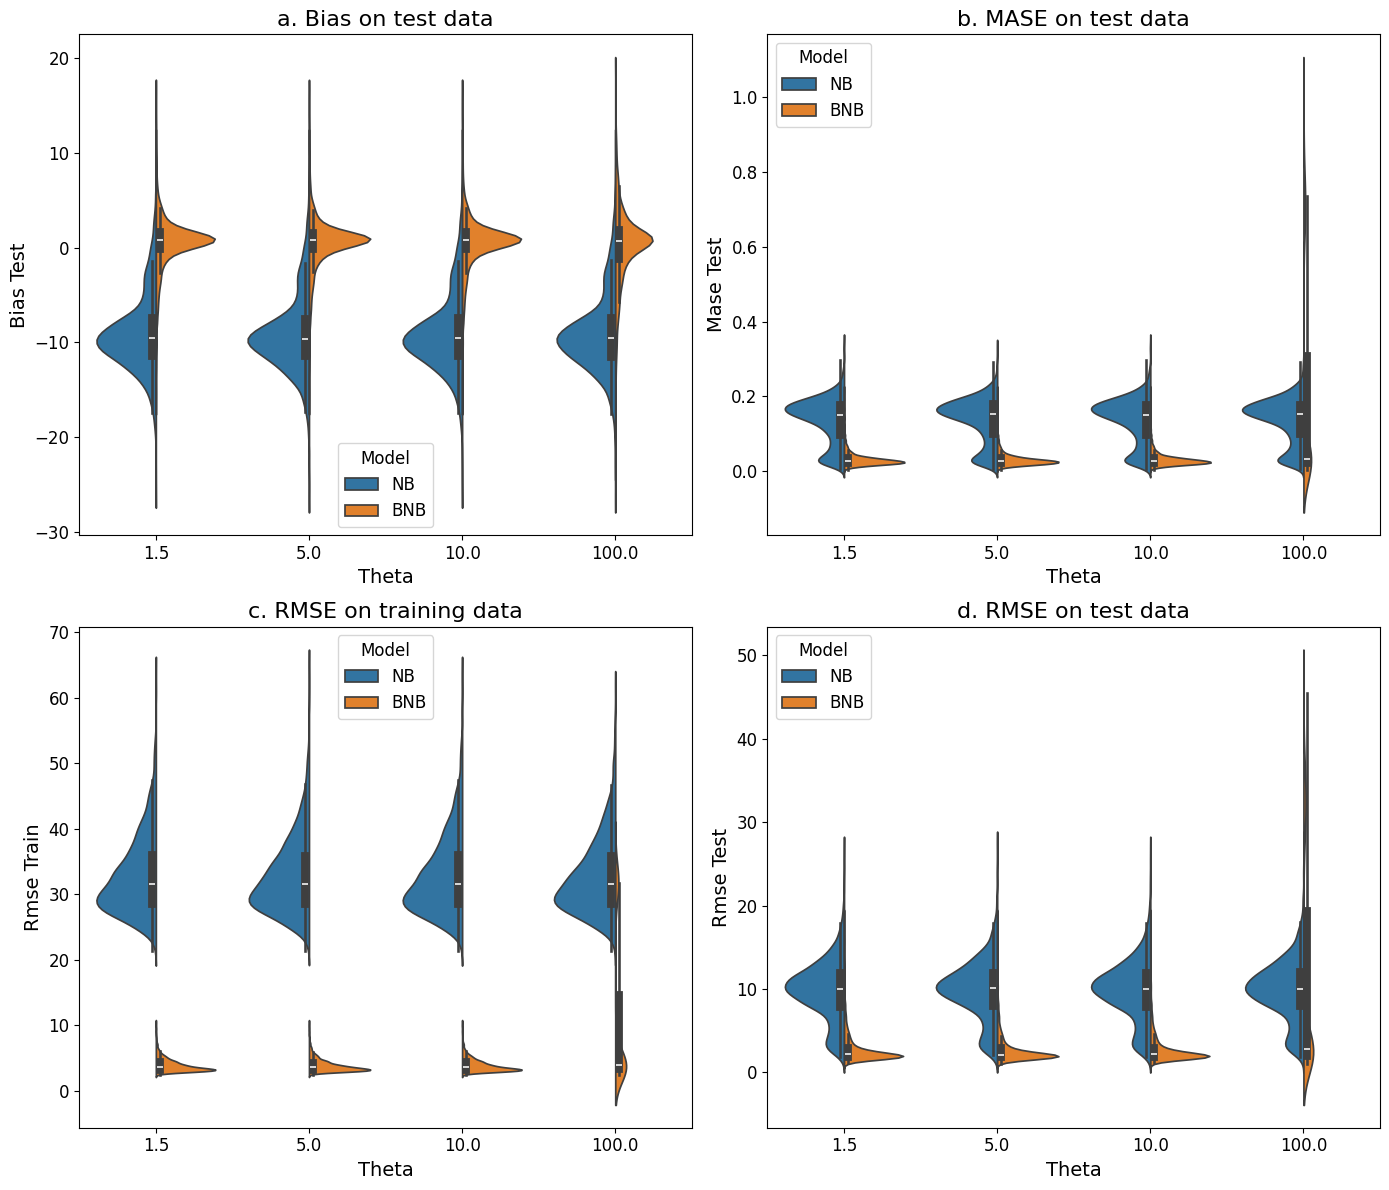

In [21]:
# 2. Violin plots by metric
# --------------------------
# R snippet translated:
#   plot1 <- finalmetrics %>% ggplot(aes(x=as.factor(theta), y=rmse_train, fill=model)) + geom_violin() + facet_wrap(~n) + theme_bw() ...
#   plot2, plot3, plot4 similarly
#   comp_plot <- grid.arrange(plot3, plot4, plot1, plot2)

metrics = [
    ('bias_test',  'a. Bias on test data'),
    ('mase_test',  'b. MASE on test data'),
    ('rmse_train','c. RMSE on training data'),
    ('rmse_test', 'd. RMSE on test data'),
]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for ax, (metric, title) in zip(axes, metrics):
    # R: geom_violin(fill = model) + facet_wrap(~n)
    sns.violinplot(
        data=finalmetrics,
        x='theta', y=metric,
        hue='model',
        split=True,                # splits violins by model
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Theta', fontsize=14)
    ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.legend(title='Model', fontsize=12, title_fontsize=12)

plt.tight_layout()
plt.show()


In [22]:
# 3. Reshape and compute summary statistics
# -----------------------------------------
# R snippet translated:
#   finalmet2 = finalmetrics %>% pivot_longer(rmse_train:bias_test, names_to="metric", values_to="value")
#   finalmet2[mapply(is.infinite, finalmet2)] <- NA
#   bias1 = finalmet2 %>% filter(metric=="bias_test") %>% group_by(model,theta,n) %>% summarize(average=mean(value,na.rm=T)) %>% pivot_wider(...)
#   ... (similarly for mase, rmse)
#   sim_results = cbind(bias1, mase1[,-c(1:2)], rmse1[,-c(1:2)], rmse2[,-c(1:2)])

# Melt to long format
finalmet2 = finalmetrics.melt(
    id_vars=['model', 'theta', 'n'],
    value_vars=['rmse_train', 'rmse_test', 'bias_test', 'mase_test'],
    var_name='metric',
    value_name='value'
)

# Replace infinities with NaN (R's is.infinite -> NA)
finalmet2['value'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Compute means by group and pivot to wide format
grouped = (
    finalmet2
    .groupby(['model', 'theta', 'n', 'metric'])['value']
    .mean()
    .reset_index()
)

pivoted = grouped.pivot_table(
    index=['theta', 'n'],
    columns=['metric', 'model'],
    values='value'
)


/tmp/ipython-input-22-3644259598.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  finalmet2['value'].replace([np.inf, -np.inf], np.nan, inplace=True)


In [23]:
mapping = {
    'bias_test':   'bias',
    'mase_test':   'mase',
    'rmse_train': 'rmse1',
    'rmse_test':  'rmse2'
}

pivoted.columns = [
    f"{model}_{mapping[metric]}"
    for metric, model in pivoted.columns
]


# Reset index for final results table
# This matches sim_results in R
sim_results = pivoted.reset_index()

print(sim_results.head())


   theta    n  BNB_bias    NB_bias  BNB_mase   NB_mase  BNB_rmse2   NB_rmse2  \
0    1.5   60 -0.404250  -4.554583  0.037482  0.051302   4.373444   5.987774   
1    1.5  120  0.898583 -11.245458  0.032127  0.144076   2.824768  11.728628   
2    1.5  240  0.803146 -10.491563  0.028643  0.171205   2.070223  10.969409   
3    1.5  360  0.713208  -9.942250  0.028895  0.176433   1.929121  10.405046   
4    5.0   60 -0.405417  -4.554667  0.037481  0.051306   4.374410   5.988052   

   BNB_rmse1   NB_rmse1  
0   4.083469  29.141510  
1   3.791044  30.110954  
2   3.888694  35.434442  
3   3.900046  36.597647  
4   4.083755  29.141724  
